#MARKET PRICE PREDICTION:
      The ultimate goal is to deploy a production-ready machine learning model capable of generating accurate
      forecasts for market quantity and prices for future months.
      
      The insights derived from this model will aid
      stakeholders in making data-driven decisions, optimizing inventory management, pricing strategies, and
      resource allocation, thereby enhancing overall efficiency and profitability in the market ecosystem.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = pd.read_csv('MarketPricePrediction.csv')

data = data.fillna(method='ffill').fillna(method='bfill')

label_encoders = {}
categorical_columns = ['market', 'state', 'city']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

<ipython-input-1-f93558e73b98>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


##Exploratory Data Analysis (EDA):
     Visualizing Quantity Over Time

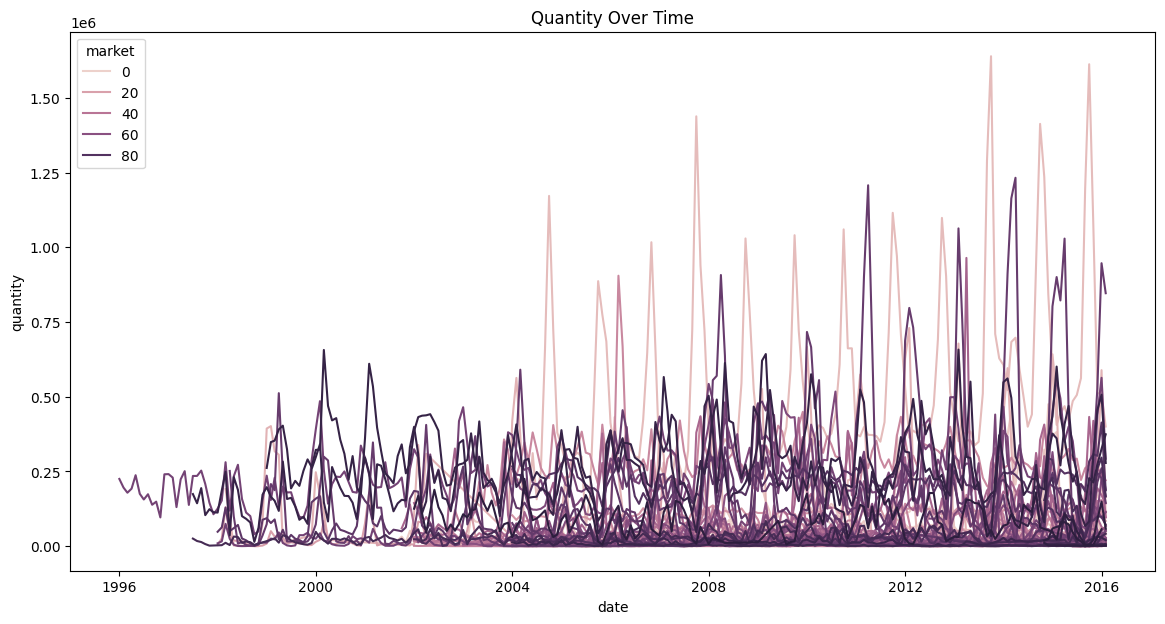

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(data=train_data, x=train_data.index, y='quantity', hue='market')
plt.title('Quantity Over Time')
plt.show()

##Feature Engineering:
      Creating Lag Features and Rolling Statistics

In [3]:
for lag in range(1, 13):
    train_data[f'quantity_lag_{lag}'] = train_data['quantity'].shift(lag)
    test_data[f'quantity_lag_{lag}'] = test_data['quantity'].shift(lag)

train_data['quantity_rolling_mean'] = train_data['quantity'].rolling(window=3).mean()
test_data['quantity_rolling_mean'] = test_data['quantity'].rolling(window=3).mean()

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)


##Model Building and Training:
    LSTM for Time Series Forecasting

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['quantity']])
test_scaled = scaler.transform(test_data[['quantity']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)


Epoch 1/50
255/255 [==============================] - 16s 36ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 2/50
255/255 [==============================] - 6s 23ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/50
255/255 [==============================] - 7s 29ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/50
255/255 [==============================] - 4s 15ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
255/255 [==============================] - 3s 13ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/50
255/255 [==============================] - 3s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/50
255/255 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/50
255/255 [==============================] - 4s 15ms/step - loss: 0.0015 - val_l

##Model Evaluation:
    Assessing LSTM Performance

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

lstm_mae, lstm_mse, lstm_rmse = evaluate(test_data['quantity'][seq_length:], lstm_pred)
print(f'LSTM MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}')

LSTM MAE: 24475.897351567754, MSE: 2847846673.327058, RMSE: 53365.219697168475
